In [16]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

from time import time
from pathlib import Path

import numpy as np
import pandas as pd

from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns
idx = pd.IndexSlice
sns.set_style('whitegrid')
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

In [17]:
# Johansen Test Critical Values
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349}, 1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

In [18]:
DATA_PATH = Path('data')
STORE = DATA_PATH / 'assets.h5'

In [19]:
def get_backtest_prices():
    with pd.HDFStore('data/data.h5') as store:
        tickers = store['tickers']

    with pd.HDFStore(STORE) as store:
        prices = (pd.concat([ store['stooq/us/nyse/stocks/prices'], store['stooq/us/nyse/etfs/prices'],
            store['stooq/us/nasdaq/etfs/prices'], store['stooq/us/nasdaq/stocks/prices']])
                  .sort_index().loc[idx[tickers.index, '2016':'2019'], :])
    print(prices.info(null_counts=True))
    prices.to_hdf('data/backtest.h5', 'prices')
    tickers.to_hdf('data/backtest.h5', 'tickers')

get_backtest_prices()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 305824 entries, ('AA.US', Timestamp('2016-01-04 00:00:00')) to ('WYNN.US', Timestamp('2019-12-31 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    305824 non-null  float64
 1   high    305824 non-null  float64
 2   low     305824 non-null  float64
 3   close   305824 non-null  float64
 4   volume  305824 non-null  float64
dtypes: float64(5)
memory usage: 13.3+ MB
None


In [20]:
# see notebook 05_cointagration_tests
stocks = pd.read_hdf('data/data.h5', 'stocks/close').loc['2015':]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 172 entries, AAPL.US to FSLR.US
dtypes: float64(172)
memory usage: 1.7 MB


In [21]:
# see notebook 05_cointagration_tests
etfs = pd.read_hdf('data/data.h5', 'etfs/close').loc['2015':]
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 132 entries, SPY.US to EWN.US
dtypes: float64(132)
memory usage: 1.3 MB


In [22]:
names = pd.read_hdf('data/data.h5', 'tickers').to_dict()
pd.Series(names).count()

304

In [23]:
# Precompute Cointegration
def test_cointegration(etfs, stocks, test_end, lookback=2):
    start = time()
    results = []
    test_start = test_end - pd.DateOffset(years=lookback) + pd.DateOffset(days=1)
    etf_tickers = etfs.columns.tolist()
    etf_data = etfs.loc[str(test_start):str(test_end)]

    stock_tickers = stocks.columns.tolist()
    stock_data = stocks.loc[str(test_start):str(test_end)]
    n = len(etf_tickers) * len(stock_tickers)
    j = 0
    for i, s1 in enumerate(etf_tickers, 1):
        for s2 in stock_tickers:
            j += 1
            if j % 1000 == 0:
                print(f'\t{j:5,.0f} ({j/n:3.1%}) | {time() - start:.2f}')
            df = etf_data.loc[:, [s1]].dropna().join(stock_data.loc[:, [s2]].dropna(), how='inner')
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                var = VAR(df)
                lags = var.select_order()
                result = [test_end, s1, s2]
                order = lags.selected_orders['aic']
                result += [coint(df[s1], df[s2], trend='c')[1], coint(df[s2], df[s1], trend='c')[1]]

            cj = coint_johansen(df, det_order=0, k_ar_diff=order)
            result += (list(cj.lr1) + list(cj.lr2) + list(cj.evec[:, cj.ind[0]]))
            results.append(result)
    return results

In [24]:
dates = stocks.loc['2016-12':'2019-6'].resample('Q').last().index
dates

DatetimeIndex(['2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30',
               '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30',
               '2018-12-31', '2019-03-31', '2019-06-30'],
              dtype='datetime64[ns]', name='date', freq='Q-DEC')

In [25]:
# Run Tests
test_results = []
columns = ['test_end', 's1', 's2', 'eg1', 'eg2', 'trace0', 'trace1', 'eig0', 'eig1', 'w1', 'w2']

for test_end in dates:
    print(test_end)
    result = test_cointegration(etfs, stocks, test_end=test_end)
    test_results.append(pd.DataFrame(result, columns=columns))

pd.concat(test_results).to_hdf('data/backtest.h5', 'cointegration_test')

2016-12-31 00:00:00
	1,000 (4.4%) | 51.54
	2,000 (8.8%) | 102.44
	3,000 (13.2%) | 152.55
	4,000 (17.6%) | 202.73
	5,000 (22.0%) | 253.32
	6,000 (26.4%) | 305.79
	7,000 (30.8%) | 357.57
	8,000 (35.2%) | 408.95
	9,000 (39.6%) | 459.78
	10,000 (44.0%) | 510.40
	11,000 (48.4%) | 561.66
	12,000 (52.9%) | 614.05
	13,000 (57.3%) | 667.86
	14,000 (61.7%) | 722.51
	15,000 (66.1%) | 775.96
	16,000 (70.5%) | 830.78
	17,000 (74.9%) | 884.10
	18,000 (79.3%) | 937.49
	19,000 (83.7%) | 990.88
	20,000 (88.1%) | 1044.43
	21,000 (92.5%) | 1097.76
	22,000 (96.9%) | 1151.63
2017-03-31 00:00:00
	1,000 (4.4%) | 53.93
	2,000 (8.8%) | 107.93
	3,000 (13.2%) | 162.38
	4,000 (17.6%) | 216.14
	5,000 (22.0%) | 270.16
	6,000 (26.4%) | 325.58
	7,000 (30.8%) | 379.33
	8,000 (35.2%) | 433.13
	9,000 (39.6%) | 487.56
	10,000 (44.0%) | 541.42
	11,000 (48.4%) | 595.25
	12,000 (52.9%) | 649.42
	13,000 (57.3%) | 704.10
	14,000 (61.7%) | 755.31
	15,000 (66.1%) | 805.55
	16,000 (70.5%) | 856.69
	17,000 (74.9%) | 907.70
	18,00

In [26]:
# Reload Test Results
test_results = pd.read_hdf('data/backtest.h5', 'cointegration_test')
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249744 entries, 0 to 22703
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   test_end  249744 non-null  datetime64[ns]
 1   s1        249744 non-null  object        
 2   s2        249744 non-null  object        
 3   eg1       249744 non-null  float64       
 4   eg2       249744 non-null  float64       
 5   trace0    249744 non-null  float64       
 6   trace1    249744 non-null  float64       
 7   eig0      249744 non-null  float64       
 8   eig1      249744 non-null  float64       
 9   w1        249744 non-null  float64       
 10  w2        249744 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 22.9+ MB


In [27]:
# Identify Cointegrated Pairs
# Significant Johansen Trace Statistic
test_results['joh_sig'] = ((test_results.trace0 > trace0_cv) & (test_results.trace1 > trace1_cv))
test_results.joh_sig.value_counts(normalize=True)

False    0.947883
True     0.052117
Name: joh_sig, dtype: float64

In [28]:
# Significant Engle Granger Test
test_results['eg'] = test_results[['eg1', 'eg2']].min(axis=1)
test_results['s1_dep'] = test_results.eg1 < test_results.eg2
test_results['eg_sig'] = (test_results.eg < .05)
test_results.eg_sig.value_counts(normalize=True)

False    0.912683
True     0.087317
Name: eg_sig, dtype: float64

In [29]:
# Comparison Engle-Granger vs Johansen
test_results['coint'] = (test_results.eg_sig & test_results.joh_sig)
test_results.coint.value_counts(normalize=True)

False    0.987439
True     0.012561
Name: coint, dtype: float64

In [30]:
test_results = test_results.drop(['eg1', 'eg2', 'trace0', 'trace1', 'eig0', 'eig1'], axis=1)
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249744 entries, 0 to 22703
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   test_end  249744 non-null  datetime64[ns]
 1   s1        249744 non-null  object        
 2   s2        249744 non-null  object        
 3   w1        249744 non-null  float64       
 4   w2        249744 non-null  float64       
 5   joh_sig   249744 non-null  bool          
 6   eg        249744 non-null  float64       
 7   s1_dep    249744 non-null  bool          
 8   eg_sig    249744 non-null  bool          
 9   coint     249744 non-null  bool          
dtypes: bool(4), datetime64[ns](1), float64(3), object(2)
memory usage: 14.3+ MB


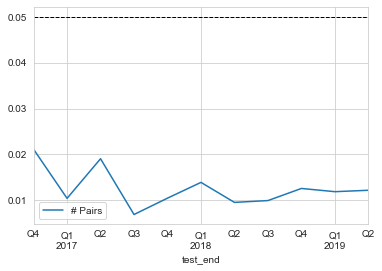

In [31]:
# Comparison
ax = test_results.groupby('test_end').coint.mean().to_frame('# Pairs').plot()
ax.axhline(.05, lw=1, ls='--', c='k');

In [32]:
# Select Candidate Pairs
def select_candidate_pairs(data):
    candidates = data[data.joh_sig | data.eg_sig]
    candidates['y'] = candidates.apply(lambda x: x.s1 if x.s1_dep else x.s2, axis=1)
    candidates['x'] = candidates.apply(lambda x: x.s2 if x.s1_dep else x.s1, axis=1)
    return candidates.drop(['s1_dep', 's1', 's2'], axis=1)
candidates = select_candidate_pairs(test_results)
candidates.to_hdf('data/backtest.h5', 'candidates')
candidates = pd.read_hdf('data/backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31686 entries, 8 to 22693
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  31686 non-null  datetime64[ns]
 1   w1        31686 non-null  float64       
 2   w2        31686 non-null  float64       
 3   joh_sig   31686 non-null  bool          
 4   eg        31686 non-null  float64       
 5   eg_sig    31686 non-null  bool          
 6   coint     31686 non-null  bool          
 7   y         31686 non-null  object        
 8   x         31686 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 1.8+ MB


<AxesSubplot: xlabel='test_end'>

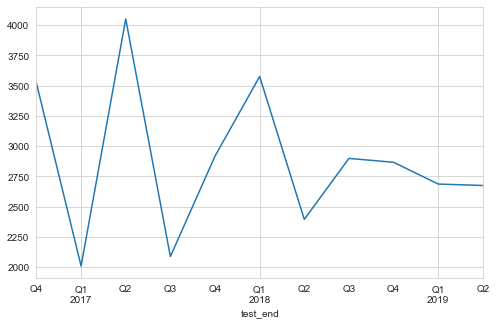

In [33]:
# Candidates over Time
candidates.groupby('test_end').size().plot(figsize=(8, 5))

In [34]:
# Most Common Pairs
with pd.HDFStore('data/data.h5') as store:
    print(store.info())
    tickers = store['tickers']

<class 'pandas.io.pytables.HDFStore'>
File path: data/data.h5
/best_params                             series       (shape->[7])          
/etfs/close                              frame        (shape->[2516,132])   
/features                                frame        (shape->[2576938,225])
/lasso/coeffs                            frame        (shape->[8,34])       
/lasso/predictions                       frame        (shape->[592432,3])   
/lasso/scores                            frame        (shape->[6000,3])     
/logistic/coeffs                         frame        (shape->[11,34])      
/logistic/predictions                    frame        (shape->[814594,4])   
/logistic/scores                         frame        (shape->[825,5])      
/lr/predictions                          frame        (shape->[74054,2])    
/lr/scores                               frame        (shape->[750,2])      
/model_data                              frame        (shape->[1926804,34]) 
/ridge/coeffs 

In [35]:
with pd.HDFStore('data/backtest.h5') as store:
    print(store.info())

counter = Counter()
for s1, s2 in zip(candidates[candidates.joh_sig & candidates.eg_sig].y,
                  candidates[candidates.joh_sig & candidates.eg_sig].x):
    if s1 > s2:
        counter[(s2, s1)] += 1
    else:
        counter[(s1, s2)] += 1
most_common_pairs = pd.DataFrame(counter.most_common(10))
most_common_pairs = pd.DataFrame(most_common_pairs[0].values.tolist(), columns=['s1', 's2'])
most_common_pairs

<class 'pandas.io.pytables.HDFStore'>
File path: data/backtest.h5
/candidates                    frame        (shape->[31686,9])  
/cointegration_test            frame        (shape->[249744,11])
/data                          frame        (shape->[190451,6]) 
/prices                        frame        (shape->[305824,5]) 
/tickers                       series       (shape->[1])        


,s1,s2
0,T.US,VOX.US
1,MDLZ.US,XOP.US
2,ERX.US,MDLZ.US
3,AMJ.US,MDLZ.US
4,MDLZ.US,VDE.US
5,DIG.US,MDLZ.US
6,DJP.US,MDLZ.US
7,GSG.US,MDLZ.US
8,FXN.US,MDLZ.US
9,OIH.US,WBA.US


In [36]:
with pd.HDFStore('data/backtest.h5') as store:
    prices = store['prices'].close.unstack('ticker').ffill(limit=5)
    tickers = store['tickers'].to_dict()
cnt = pd.Series(counter).reset_index()
cnt.columns = ['s1', 's2', 'n']
cnt['name1'] = cnt.s1.map(tickers)
cnt['name2'] = cnt.s2.map(tickers)
cnt.nlargest(10, columns='n')

,s1,s2,n,name1,name2
1151,T.US,VOX.US,6,AT&T,VANGUARD COMMUNICATION SERVICES ETF
494,MDLZ.US,XOP.US,5,MONDELEZ INT,SPDR S&P OIL & GAS EXPLORATION & PRODUCTION ETF
525,ERX.US,MDLZ.US,5,DIREXION DAILY ENERGY BULL 2X SHARES,MONDELEZ INT
529,AMJ.US,MDLZ.US,5,JPMORGAN ALERIAN MLP INDEX ETN,MONDELEZ INT
555,MDLZ.US,VDE.US,5,MONDELEZ INT,VANGUARD ENERGY ETF
563,DIG.US,MDLZ.US,5,PROSHARES ULTRA ENERGY,MONDELEZ INT
583,DJP.US,MDLZ.US,5,IPATH BLOOMBERG COMMODITY INDEX TR ETN,MONDELEZ INT
604,GSG.US,MDLZ.US,5,ISHARES S&P GSCI COMMODITY INDEXED TRUST,MONDELEZ INT
613,FXN.US,MDLZ.US,5,FIRST TRUST ENERGY ALPHADEX FUND,MONDELEZ INT
50,OIH.US,WBA.US,4,VANECK OIL SERVICES ETF,WALGREENS BOOTS ALLIANCE


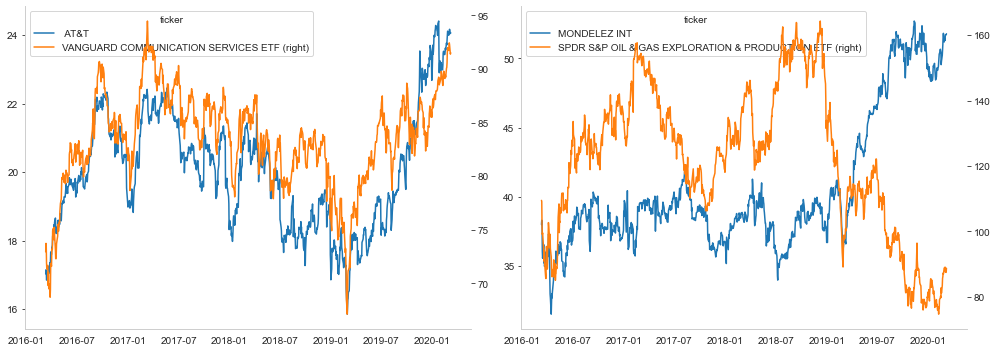

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for i in [0, 1]:
    s1, s2 = most_common_pairs.at[i, 's1'], most_common_pairs.at[i, 's2']
    prices.loc[:, [s1, s2]].rename(columns=tickers).plot(secondary_y=tickers[s2], ax=axes[i], rot=0)
    axes[i].grid(False)
    axes[i].set_xlabel('')

sns.despine()
fig.tight_layout()

In [38]:
# Get Entry and Exit Dates
# Smooth prices using Kalman filter
def KFSmoother(prices):
    """Estimate rolling mean"""
    kf = KalmanFilter(transition_matrices=np.eye(1), observation_matrices=np.eye(1),
                      initial_state_mean=0, initial_state_covariance=1,
                      observation_covariance=1, transition_covariance=.05)

    state_means, _ = kf.filter(prices.values)
    return pd.Series(state_means.flatten(), index=prices.index)

In [39]:
smoothed_prices = prices.apply(KFSmoother)
smoothed_prices.to_hdf('data/tmp.h5', 'smoothed')
smoothed_prices = pd.read_hdf('data/tmp.h5', 'smoothed')

In [40]:
# Compute rolling hedge ratio using Kalman Filter
def KFHedgeRatio(x, y):
    """Estimate Hedge Ratio"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)), transition_matrices=np.eye(2),
                      observation_matrices=obs_mat, observation_covariance=2, transition_covariance=trans_cov)

    state_means, _ = kf.filter(y.values)
    return -state_means

In [41]:
# Estimate mean reversion half life by Ornstein-Uhlenbeck Process: dXt=θ(μ−Xt)dt+σdWt
def estimate_half_life(spread):
    X = spread.shift().iloc[1:].to_frame().assign(const=1)
    y = spread.diff().iloc[1:]
    beta = (np.linalg.inv(X.T @ X) @ X.T @ y).iloc[0]
    halflife = int(round(-np.log(2) / beta, 0))
    return max(halflife, 1)

In [42]:
# Compute Spread & Bollinger Bands
def get_spread(candidates, prices):
    pairs = []
    half_lives = []

    periods = pd.DatetimeIndex(sorted(candidates.test_end.unique()))
    start = time()
    for p, test_end in enumerate(periods, 1):
        start_iteration = time()

        period_candidates = candidates.loc[candidates.test_end == test_end, ['y', 'x']]
        trading_start = test_end + pd.DateOffset(days=1)
        t = trading_start - pd.DateOffset(years=2)
        T = trading_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
        max_window = len(prices.loc[t: test_end].index)
        print(test_end.date(), len(period_candidates))
        for i, (y, x) in enumerate(zip(period_candidates.y, period_candidates.x), 1):
            if i % 1000 == 0:
                msg = f'{i:5.0f} | {time() - start_iteration:7.1f} | {time() - start:10.1f}'
                print(msg)
            pair = prices.loc[t: T, [y, x]]
            pair['hedge_ratio'] = KFHedgeRatio(y=KFSmoother(prices.loc[t: T, y]),
                                               x=KFSmoother(prices.loc[t: T, x]))[:, 0]
            pair['spread'] = pair[y].add(pair[x].mul(pair.hedge_ratio))
            half_life = estimate_half_life(pair.spread.loc[t: test_end])

            spread = pair.spread.rolling(window=min(2 * half_life, max_window))
            pair['z_score'] = pair.spread.sub(spread.mean()).div(spread.std())
            pairs.append(pair.loc[trading_start: T].assign(s1=y, s2=x, period=p, pair=i).drop([x, y], axis=1))

            half_lives.append([test_end, y, x, half_life])
    return pairs, half_lives
candidates = pd.read_hdf('data/backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31686 entries, 8 to 22693
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  31686 non-null  datetime64[ns]
 1   w1        31686 non-null  float64       
 2   w2        31686 non-null  float64       
 3   joh_sig   31686 non-null  bool          
 4   eg        31686 non-null  float64       
 5   eg_sig    31686 non-null  bool          
 6   coint     31686 non-null  bool          
 7   y         31686 non-null  object        
 8   x         31686 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 1.8+ MB


In [43]:
pairs, half_lives = get_spread(candidates, smoothed_prices)

2016-12-31 3520
 1000 |   190.1 |      190.1
 2000 |   390.6 |      390.6
 3000 |   589.3 |      589.3
2017-03-31 2009
 1000 |   226.4 |      916.2
 2000 |   455.9 |     1145.8
2017-06-30 4052
 1000 |   266.5 |     1414.6
 2000 |   535.3 |     1683.4
 3000 |   806.0 |     1954.1
 4000 |  1066.5 |     2214.6
2017-09-30 2088
 1000 |   291.2 |     2519.4
 2000 |   591.4 |     2819.5
2017-12-31 2918
 1000 |   329.9 |     3175.6
 2000 |   657.4 |     3503.0
2018-03-31 3576
 1000 |   332.6 |     4141.1
 2000 |   660.9 |     4469.5
 3000 |   987.3 |     4795.9
2018-06-30 2395
 1000 |   328.5 |     5312.2
 2000 |   654.0 |     5637.7
2018-09-30 2899
 1000 |   333.2 |     6103.0
 2000 |   666.7 |     6436.5
2018-12-31 2867
 1000 |   332.6 |     7065.7
 2000 |   658.5 |     7391.7
2019-03-31 2687
 1000 |   339.0 |     8017.8
 2000 |   679.6 |     8358.4
2019-06-30 2675
 1000 |   337.4 |     8928.0
 2000 |   671.4 |     9262.0


In [44]:
# Collect Results
# Half Lives
hl = pd.DataFrame(half_lives, columns=['test_end', 's1', 's2', 'half_life'])
hl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31686 entries, 0 to 31685
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   test_end   31686 non-null  datetime64[ns]
 1   s1         31686 non-null  object        
 2   s2         31686 non-null  object        
 3   half_life  31686 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 990.3+ KB


In [45]:
hl.half_life.describe()

count    31686.000000
mean        25.017737
std          8.466813
min          5.000000
25%         20.000000
50%         24.000000
75%         28.000000
max        261.000000
Name: half_life, dtype: float64

In [46]:
hl.to_hdf('data/backtest.h5', 'half_lives')

In [47]:
# Pair Data
pair_data = pd.concat(pairs)
pair_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3981903 entries, 2017-01-03 to 2019-12-31
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   hedge_ratio  3981903 non-null  float64
 1   spread       3981903 non-null  float64
 2   z_score      3981903 non-null  float64
 3   s1           3981903 non-null  object 
 4   s2           3981903 non-null  object 
 5   period       3981903 non-null  int64  
 6   pair         3981903 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 243.0+ MB


In [48]:
pair_data.to_hdf('data/backtest.h5', 'pair_data')
pair_data = pd.read_hdf('data/backtest.h5', 'pair_data')

In [49]:
# Identify Long & Short Entry and Exit Dates
def get_trades(data):
    pair_trades = []
    for i, ((period, s1, s2), pair) in enumerate(data.groupby(['period', 's1', 's2']), 1):
        if i % 100 == 0:
            print(i)

        # clear the position in 3 month
        first3m = pair.first('3M').index
        last3m = pair.last('3M').index

        entry = pair.z_score.abs() > 2 # spread range : +- 2 standard deviation from mean
        entry = ((entry.shift() != entry).mul(np.sign(pair.z_score)).fillna(0).astype(int).sub(2))

        exit = (np.sign(pair.z_score.shift().fillna(method='bfill')) != np.sign(pair.z_score)).astype(int) - 1

        trades = (entry[entry != -2].append(exit[exit == 0]).to_frame('side').sort_values(['date', 'side']).squeeze())
        if not isinstance(trades, pd.Series):
            continue
        try:
            trades.loc[trades < 0] += 2
        except:
            print(type(trades))
            print(trades)
            print(pair.z_score.describe())
            break

        trades = trades[trades.abs().shift() != trades.abs()]
        window = trades.loc[first3m.min():first3m.max()]
        extra = trades.loc[last3m.min():last3m.max()]
        n = len(trades)

        if window.iloc[0] == 0:
            if n > 1:
                print('shift')
                window = window.iloc[1:]
        if window.iloc[-1] != 0:
            extra_exits = extra[extra == 0].head(1)
            if extra_exits.empty:
                continue
            else:
                window = window.append(extra_exits)

        trades = pair[['s1', 's2', 'hedge_ratio', 'period', 'pair']].join(window.to_frame('side'), how='right')
        trades.loc[trades.side == 0, 'hedge_ratio'] = np.nan
        trades.hedge_ratio = trades.hedge_ratio.ffill()
        pair_trades.append(trades)
    return pair_trades
pair_trades = get_trades(pair_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [50]:
pair_trade_data = pd.concat(pair_trades)
pair_trade_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126842 entries, 2017-01-03 to 2019-10-04
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   s1           126842 non-null  object 
 1   s2           126842 non-null  object 
 2   hedge_ratio  126842 non-null  float64
 3   period       126842 non-null  int64  
 4   pair         126842 non-null  int64  
 5   side         126842 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(2)
memory usage: 6.3+ MB


In [51]:
pair_trade_data.head()

,s1,s2,hedge_ratio,period,pair,side
date,,,,,,
2017-01-03,AA.US,DEM.US,-1.037475,1,2244,-1
2017-01-13,AA.US,DEM.US,-1.037475,1,2244,0
2017-01-03,AA.US,DIG.US,-0.600162,1,1978,-1
2017-01-10,AA.US,DIG.US,-0.600162,1,1978,0
2017-01-03,AA.US,DWX.US,-1.036419,1,3053,-1


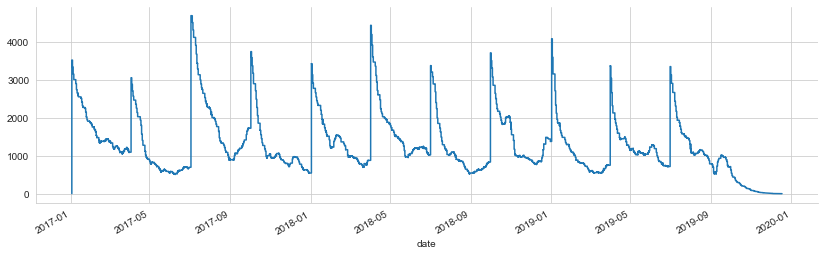

In [52]:
trades = pair_trade_data['side'].copy()
trades.loc[trades != 0] = 1
trades.loc[trades == 0] = -1
trades.sort_index().cumsum().plot(figsize=(14, 4))
sns.despine()

In [53]:
pair_trade_data.to_hdf('data/backtest.h5', 'pair_trades')